In [1]:
IMG_HELP_PATH = '/Users/shankar/dev/code/ds/studies/data_science/trading/honchar'
import os
import sys
sys.path.append(os.path.abspath(IMG_HELP_PATH))
from common.preprocessing import split_train_test_in_unison

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

In [3]:
def data2change(data):
    change = pd.DataFrame(data).pct_change()
    change = change.replace([np.inf, -np.inf], np.nan)
    change = change.fillna(0.0).values.tolist()
    change = [c[0] for c in change]
    return change

In [4]:
WINDOW = 30
EMB_SIZE = 6
STEP = 1
FORECAST = 1

In [5]:
data = pd.read_csv('../datasets/apple/AAPL.csv')[::-1]

In [6]:
openp = data.loc[:, 'Open'].tolist()
highp = data.loc[:, 'High'].tolist()
lowp = data.loc[:, 'Low'].tolist()
closep = data.loc[:, 'Adj Close'].tolist()
volumep = data.loc[:, 'Volume'].tolist()

In [7]:
openp = data2change(openp)
highp = data2change(highp)
lowp = data2change(lowp)
closep = data2change(closep)
volumep = data2change(volumep)

In [8]:
volatility = []

for i in range(WINDOW, len(openp)):
    window = highp[i - WINDOW:i]
    volatility.append(np.std(window))
    
openp, highp, lowp, closep, volumep = openp[WINDOW:], highp[WINDOW:], lowp[WINDOW:], closep[WINDOW:], volumep[WINDOW:]

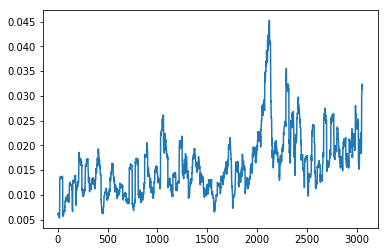

In [9]:
plt.plot(volatility)
plt.show()

In [10]:
X, Y = [], []
for i in range(0, len(data), STEP):
    try:
        o = openp[i: i + WINDOW]
        h = highp[i: i + WINDOW]
        l = lowp[i: i + WINDOW]
        c = closep[i: i + WINDOW]
        v = volumep[i: i+ WINDOW]
        
        volat = volatility[i:i+WINDOW]
        
        y_i = volatility[i+WINDOW+FORECAST]
        x_i = np.column_stack((volat, o, h, l, c, v))
    
    except Exception as e:
        break
    
    X.append(x_i)
    Y.append(y_i)

In [11]:
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = split_train_test_in_unison(X, Y)

In [12]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

In [13]:
epsilon = 1.0e-9
from common.nn.conv import HNet2LayerRegression

/anaconda3/envs/dlcv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
model = HNet2LayerRegression.build((WINDOW, EMB_SIZE))

In [16]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Nadam
opt = Nadam(lr=0.002)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="../output/volatility.hdf5", verbose=1, save_best_only=True)


In [18]:
from keras import backend as K
def mse_log(y, y_hat):
    y_hat = K.clip(y_hat, epsilon, 1.0 - epsilon)
    loss = K.square(K.log(y) - K.log(y_hat))
    return K.mean(loss, axis=-1)
    
model.compile(optimizer=opt, loss=mse_log)

Train on 2422 samples, validate on 606 samples
Epoch 1/100
2422/2422 [==============================] - 0s 108us/step - loss: 10.8728 - val_loss: 5.3438

Epoch 00001: val_loss improved from 11.19760 to 5.34376, saving model to ../output/volatility.hdf5
Epoch 2/100
2422/2422 [==============================] - 0s 98us/step - loss: 33.4142 - val_loss: 4.9599

Epoch 00002: val_loss improved from 5.34376 to 4.95988, saving model to ../output/volatility.hdf5
Epoch 3/100
2422/2422 [==============================] - 0s 99us/step - loss: 25.7182 - val_loss: 8.2439

Epoch 00003: val_loss did not improve
Epoch 4/100
2422/2422 [==============================] - 0s 108us/step - loss: 15.9654 - val_loss: 4.7756

Epoch 00004: val_loss improved from 4.95988 to 4.77565, saving model to ../output/volatility.hdf5
Epoch 5/100
2422/2422 [==============================] - 0s 103us/step - loss: 16.7113 - val_loss: 4.4899

Epoch 00005: val_loss improved from 4.77565 to 4.48985, saving model to ../output/volat

No handles with labels found to put in legend.


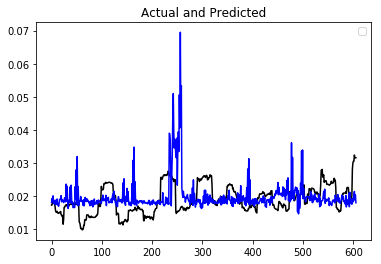

4.239878072290682e-05
0.004455921666207139
0.2499078195995392


In [20]:
try:
    H = model.fit(X_train, Y_train, epochs=100,
        batch_size=256, verbose=1, validation_data=(X_test, Y_test),
        callbacks=[reduce_lr, checkpointer], shuffle=True)
except Exception as e:
    print(e)
finally:
    model.load_weights('../output/volatility.hdf5')
    pred = model.predict(X_test)
    predicted = pred
    original = Y_test
    plt.title('Actual and Predicted')
    plt.legend(loc='best')
    plt.plot(original, color='black', label='Original Data')
    plt.plot(predicted, color='blue', label='Predicted Data')
    plt.show()
    print(np.mean(np.square(predicted - original)))
    print(np.mean(np.abs(predicted - original)))
    print(np.mean(np.abs(original - predicted)/original))